In [14]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import tensorflow as tf
import requests
import zipfile
from PIL import Image
from tqdm.notebook import tqdm
import shutil
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, save_img
import random
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import TensorBoard
import datetime
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pydot
import graphviz
import os
from tqdm.notebook import tqdm
from tensorflow.keras.preprocessing.sequence import pad_sequences

row_data = "./test_data/row_data/"
processed_data = "./test_data/processed_data/"
denoised_data = "./test_data/denoised_data/"
classified_data = "./test_data/classified_data/"

image_valid_extensions = [".png", ".jpg", ".jpeg"]
batch_size = 32

In [2]:
def process_images(source_directory, destination_directory, target_size, valid_extensions):
    if os.path.exists(destination_directory):
        shutil.rmtree(destination_directory)
    
    # Créer le dossier de destination s'il n'existe pas
    if not os.path.exists(destination_directory):
        os.makedirs(destination_directory)

    for file_name in tqdm(os.listdir(source_directory), desc="File", position=1, leave=False):
        if any(file_name.endswith(extension) for extension in valid_extensions):
            source_file_path = os.path.join(source_directory, file_name)
            transient_file_path = os.path.join(destination_directory, "transient_" + file_name)
            destination_file_path = os.path.join(destination_directory, file_name)
            try:
                # Convertir l'image en RGB et redimensionner avec PIL
                with Image.open(source_file_path) as img:
                    img_rgb = img.convert('RGB')
                    img_resized = img_rgb.resize(target_size)
                    img_resized.save(transient_file_path, "JPEG")

                # Lire et vérifier l'image avec TensorFlow
                image = tf.io.read_file(transient_file_path)
                image = tf.image.decode_image(image)

                # Normaliser l'image
                #image = tf.image.convert_image_dtype(image, tf.float32, saturate=True)

                # Enregistrer l'image traitée
                encoded_image = tf.image.encode_jpeg(tf.image.convert_image_dtype(image, dtype=tf.uint8, saturate=True))
                tf.io.write_file(destination_file_path, encoded_image)

            except Exception as e:
                print(f"Erreur lors du traitement de l'image {source_file_path}: {e}")

            if os.path.exists(transient_file_path):
                os.remove(transient_file_path)

    print("Traitement terminé!")
    
process_images(row_data, processed_data, (300, 300), image_valid_extensions)

File:   0%|          | 0/53 [00:00<?, ?it/s]

Traitement terminé!


In [3]:
classifier = load_model('./models/binary-classifier.h5')

dataset = tf.keras.utils.image_dataset_from_directory(
        processed_data,
        labels='inferred',
        label_mode=None,
        class_names=None,
        color_mode='rgb',
        batch_size=batch_size,
        image_size=(150, 150),
        shuffle=False
    )

def normalize(image):
    return tf.multiply(image, 1./255)

Found 53 files belonging to 1 classes.


In [4]:
batch_count = 0
for batch in tqdm(dataset):
    batch_count = batch_count + 1
    images = batch  
    predictions = classifier.predict(normalize(images), verbose=False) 
    predictions = tf.round(predictions).numpy().flatten()
    for i in range(len(predictions)):
        prediction = predictions[i] 
        image_path = dataset.file_paths[i + (32*(batch_count-1))]
        if prediction == 1:
            image_filename = os.path.basename(image_path)
            destination_path = os.path.join(f"{classified_data}/photos/", image_filename)
        elif prediction == 0:
            image_filename = os.path.basename(image_path)
            destination_path = os.path.join(f"{classified_data}/not-photos/", image_filename)
            
        tf.io.gfile.copy(image_path, destination_path, overwrite=True)

  0%|          | 0/2 [00:00<?, ?it/s]

In [8]:
dataset = tf.keras.utils.image_dataset_from_directory(
    f"{classified_data}/photos",
    labels='inferred',
    label_mode=None,
    class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(304, 304),
    shuffle=False
)
dataset = dataset.map(lambda x: x / 255.0, num_parallel_calls=tf.data.experimental.AUTOTUNE)

dae = load_model('./models/dae.h5')

Found 36 files belonging to 1 classes.


In [9]:
for i, batch in enumerate(tqdm(dataset)):
    predictions = dae.predict(batch, verbose=False)
    for j, img in enumerate(predictions):
        filename = f"{denoised_data}/denoised_img_{i * batch_size + j}.png"
        save_img(filename, img)

  0%|          | 0/2 [00:00<?, ?it/s]

In [10]:
import os
from skimage import io
import numpy as np
import cv2

# Ajustez le chemin du dossier en fonction de l'endroit où vos images sont stockées
data_directory = denoised_data
dataset = {os.path.join(data_directory, img): None for img in os.listdir(data_directory) if img.endswith('.png')} # or another image format if needed


In [11]:
from keras.applications import Xception

image_features = {}
filename = './image_features.pkl'
BATCH_SIZE = 8

model = Xception(include_top=False, pooling='avg')
images_list = list(dataset.keys())
num_batches = len(images_list) // BATCH_SIZE + (1 if len(images_list) % BATCH_SIZE != 0 else 0)

for i in tqdm(range(num_batches)):
    batch_images = images_list[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
    batch_data = []
    
    for img in batch_images:
        try:
            image = io.imread(img)
            if image.ndim != 3:
                image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
            image = cv2.resize(image, (299, 299))
            batch_data.append(image)
        except Exception as e:
            print(f"Erreur de traitement sur {img} : {e}")
    
    batch_data = np.array(batch_data)
    batch_data = batch_data / 127.5
    batch_data = batch_data - 1.0
    batch_features = model.predict(batch_data, verbose=False)
    
    for img, feature in zip(batch_images, batch_features):
        image_features[img] = feature

  0%|          | 0/5 [00:00<?, ?it/s]

In [12]:
from keras.models import load_model
import pickle

# Charger le modèle et le tokenizer
model_path = './models/captioner.h5'
tokenizer_path = './tokenizer.pkl'

captioning_model = load_model(model_path)

with open(tokenizer_path, 'rb') as file:
    tokenizer = pickle.load(file)

In [15]:
def generate_descriptions_batch(model, tokenizer, photos, max_length):
    batch_size = photos.shape[0]
    batch_descriptions = ['start'] * batch_size

    for _ in range(max_length):
        sequences = tokenizer.texts_to_sequences(batch_descriptions)
        sequences = pad_sequences(sequences, maxlen=max_length)
        
        preds = model.predict([photos, sequences], verbose=0)
        
        for i, pred in enumerate(preds):
            pred_word_index = np.argmax(pred)
            word = tokenizer.index_word.get(pred_word_index, '')
            
            if word == 'end' or len(batch_descriptions[i].split()) > max_length:
                continue
            
            batch_descriptions[i] += ' ' + word
    
    return batch_descriptions

batch_size = 32  # Vous pouvez ajuster la taille du lot en fonction de votre mémoire disponible
captions = {}
keys_list = list(image_features.keys())
for i in tqdm(range(0, len(keys_list), batch_size)):
    batch_keys = keys_list[i:i+batch_size]
    batch_features = np.array([image_features[key] for key in batch_keys])

    batch_captions = generate_descriptions_batch(captioning_model, tokenizer, batch_features, 51)

    for key, caption in zip(batch_keys, batch_captions):
        captions[key] = caption.strip()



  0%|          | 0/2 [00:00<?, ?it/s]

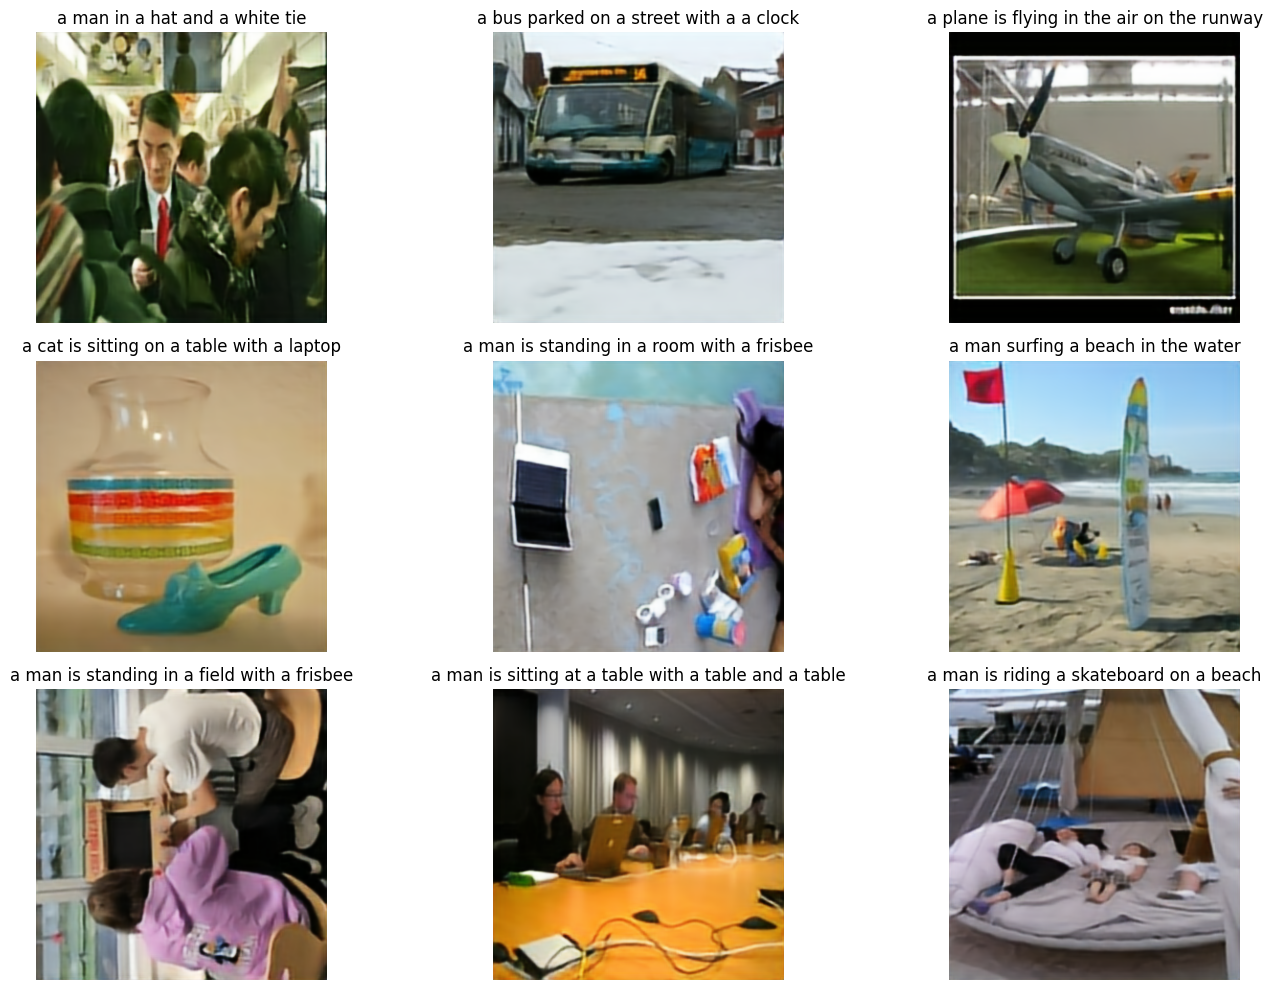

In [23]:
import matplotlib.pyplot as plt
import io
from skimage import io as skio
import random

# Sélectionner 9 clés (images) aléatoires pour l'affichage
selected_keys = random.sample(list(captions.keys()), 9)

plt.figure(figsize=(15, 10))

for idx, key in enumerate(selected_keys):
    # Charger l'image
    image = skio.imread(key)
    
    # Afficher l'image
    plt.subplot(3, 3, idx+1)
    plt.imshow(image)
    plt.axis('off')
    
    # Retirer le mot 'start' de la légende et afficher le reste comme titre
    caption = captions[key].replace('start', '').strip()
    plt.title(caption)

plt.tight_layout()
plt.show()


In [24]:
# Créer ou ouvrir un fichier texte en mode écriture
with open('./test_data/image_captions.txt', 'w') as file:
    for key, caption in captions.items():
        # Retirer le mot 'start' de la légende
        clean_caption = caption.replace('start', '').strip()
        # Écrire le chemin de l'image et la légende dans le fichier
        file.write(f"{key}\t{clean_caption}\n")
